
# Sales Analysis Project – AusApparalSales (4th Quarter 2020)

This notebook performs an **end-to-end sales analysis** for the given dataset `AusApparalSales4thQrt2020.csv` as per the project requirements.

---


In [210]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


In [211]:
# Step 2: Load Dataset
df = pd.read_csv("AusApparalSales4thQrt2020.csv")
df.head()


,Date,Time,State,Group,Unit,Sales
0,1-Oct-2020,Morning,WA,Kids,8,20000
1,1-Oct-2020,Morning,WA,Men,8,20000
2,1-Oct-2020,Morning,WA,Women,4,10000
3,1-Oct-2020,Morning,WA,Seniors,15,37500
4,1-Oct-2020,Afternoon,WA,Kids,3,7500


In [212]:
# Step 3: Dataset Information
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    7560 non-null   object
 1   Time    7560 non-null   object
 2   State   7560 non-null   object
 3   Group   7560 non-null   object
 4   Unit    7560 non-null   int64 
 5   Sales   7560 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 354.5+ KB


In [213]:
# Step 4: Summary Statistics
df.describe(include="all")


,Date,Time,State,Group,Unit,Sales
count,7560,7560,7560,7560,7560.000000,7560.000000
unique,90,3,7,4,NaN,NaN
top,1-Oct-2020,Morning,WA,Kids,NaN,NaN
freq,84,2520,1080,1890,NaN,NaN
mean,NaN,NaN,NaN,NaN,18.005423,45013.558201
std,NaN,NaN,NaN,NaN,12.901403,32253.506944
min,NaN,NaN,NaN,NaN,2.000000,5000.000000
25%,NaN,NaN,NaN,NaN,8.000000,20000.000000
50%,NaN,NaN,NaN,NaN,14.000000,35000.000000
75%,NaN,NaN,NaN,NaN,26.000000,65000.000000


In [214]:
# Step 5: Missing Values Check
df.isnull().sum()


Date     0
Time     0
State    0
Group    0
Unit     0
Sales    0
dtype: int64

In [215]:
# Step 6: Handle Missing Values (safe)

# make sure df is a real copy
df = df.copy()

# numeric columns -> fill with mean
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean(numeric_only=True))

# non-numeric columns -> fill with mode
cat_cols = df.select_dtypes(exclude=np.number).columns
for col in cat_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode().iloc[0])

# verify
df.isna().sum()



Date     0
Time     0
State    0
Group    0
Unit     0
Sales    0
dtype: int64

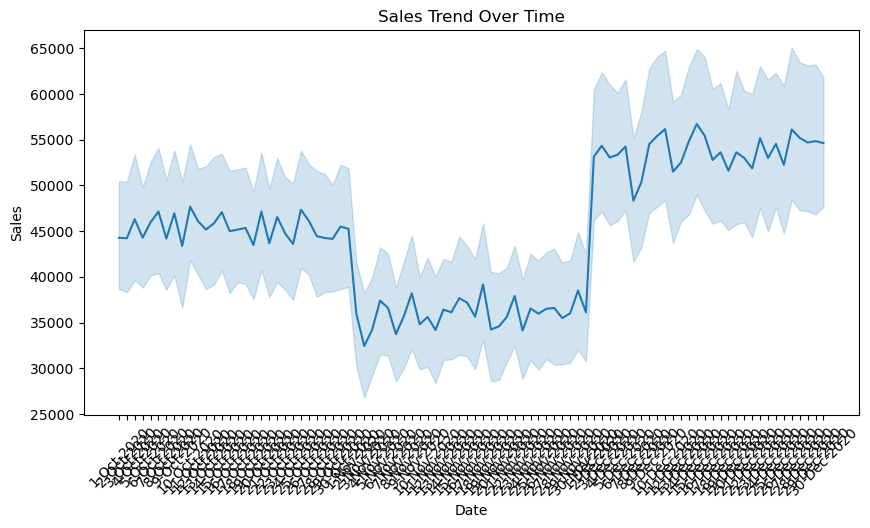

In [216]:
# Step 7: Sales Trend Visualization
plt.figure(figsize=(10,5))
sns.lineplot(x='Date', y='Sales', data=df)
plt.xticks(rotation=45)
plt.title('Sales Trend Over Time')
plt.show()


,Group,Sales
1,Men,85750000
3,Women,85442500
0,Kids,85072500
2,Seniors,84037500


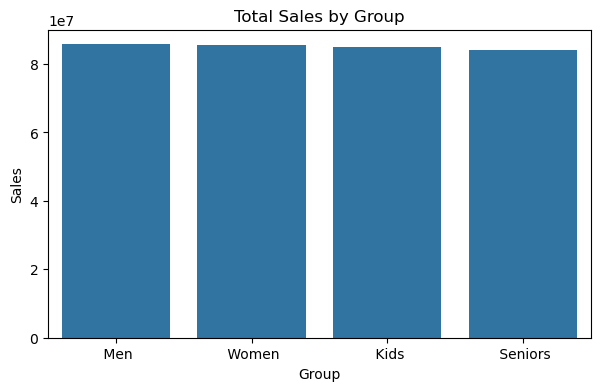

In [217]:
# Step 8: Group-wise Total Sales
group_totals = (
    df.groupby("Group", as_index=False)["Sales"]
      .sum()
      .sort_values("Sales", ascending=False)
)
display(group_totals)

plt.figure(figsize=(7,4))
sns.barplot(data=group_totals, x="Group", y="Sales")
plt.title("Total Sales by Group")
plt.show()



,State,Sales
5,VIC,97745.370370
0,NSW,69416.666667
3,SA,54497.685185
2,QLD,30942.129630
4,TAS,21074.074074
1,NT,20907.407407
6,WA,20511.574074


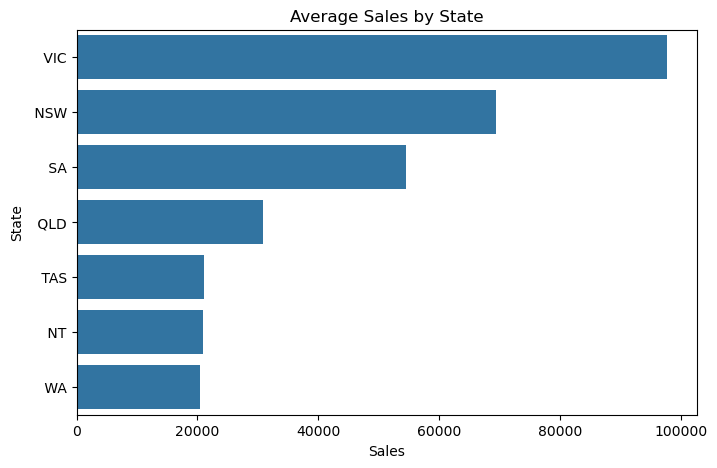

In [218]:
# Step 9: State-wise Average Sales
state_avg_sales = (
    df.groupby("State", as_index=False)["Sales"]
      .mean()
      .sort_values("Sales", ascending=False)
)
display(state_avg_sales)

plt.figure(figsize=(8,5))
sns.barplot(data=state_avg_sales, x="Sales", y="State")
plt.title("Average Sales by State")
plt.show()


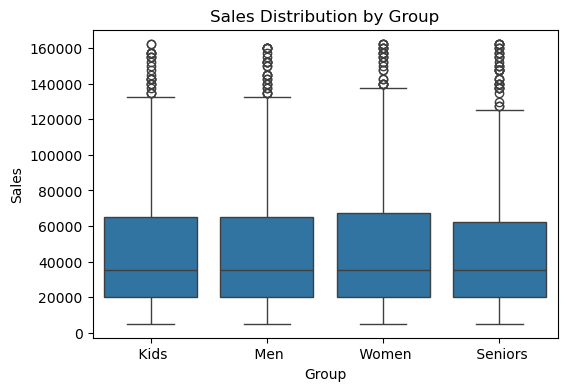

In [219]:
# Step 10: Sales Distribution by Group
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Group", y="Sales")
plt.title("Sales Distribution by Group")
plt.show()


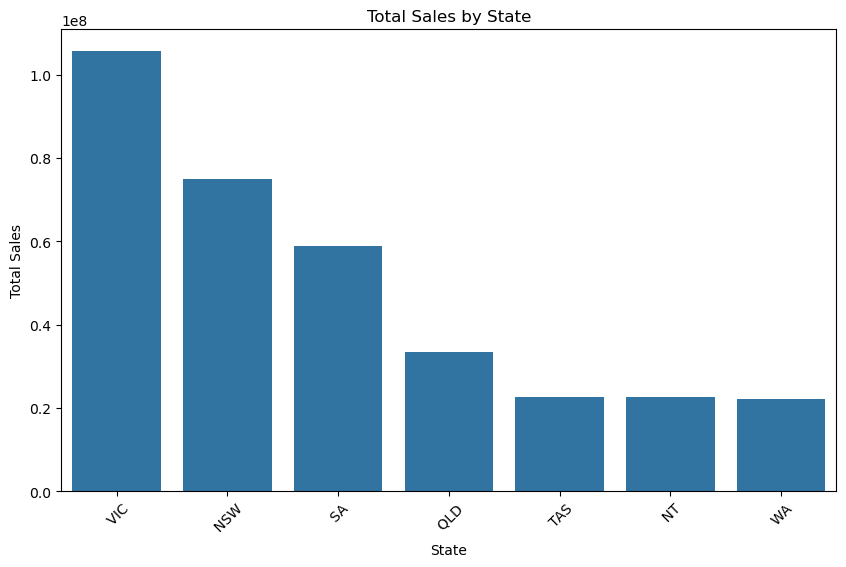

In [220]:
# Step 11: State-wise Total Sales
state_sales = df.groupby("State")["Sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=state_sales.index, y=state_sales.values)
plt.xticks(rotation=45)
plt.title("Total Sales by State")
plt.ylabel("Total Sales")
plt.xlabel("State")
plt.show()


Group,Kids,Men,Seniors,Women
State,,,,
NSW,18587500,19022500,18187500,19172500
NT,5700000,5762500,5465000,5652500
QLD,8510000,8392500,8190000,8325000
SA,14515000,14655000,14717500,14970000
TAS,5775000,5757500,5650000,5577500
VIC,26360000,26407500,26315000,26482500
WA,5625000,5752500,5512500,5262500


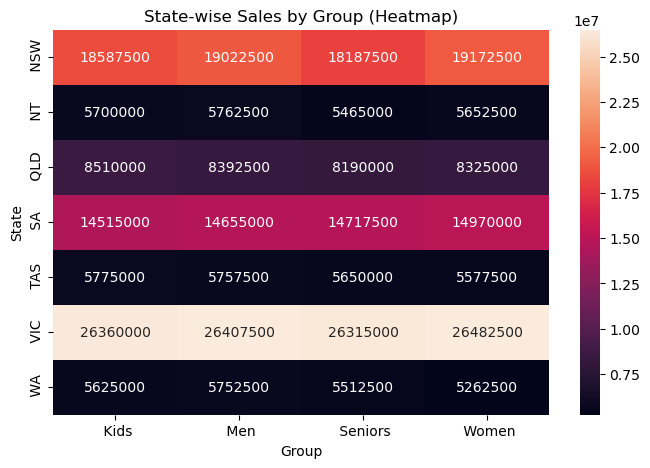

In [221]:
# Step 12: State × Group heatmap 
# ---------------------------------------------------------------
# Goal: State-wise AND Group-wise sales  visualization.
# y-axis = State, x-axis = Group, cells = Total Sales.

pivot_sg = df.pivot_table(
    index="State",
    columns="Group",
    values="Sales",
    aggfunc="sum"
).fillna(0)

display(pivot_sg)  # table view

plt.figure(figsize=(8,5))
sns.heatmap(pivot_sg, annot=True, fmt=".0f")
plt.title("State-wise Sales by Group (Heatmap)")
plt.ylabel("State")
plt.xlabel("Group")
plt.show()





In [222]:

# Step 13: Weekly / Monthly / Quarterly Sales Analysis 

# Make sure 'Date' column is in datetime format
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Create Week, Month, Quarter columns
df["Week"]    = df["Date"].dt.isocalendar().week
df["Month"]   = df["Date"].dt.month
df["Quarter"] = df["Date"].dt.quarter

# Group by Week
weekly_sales = df.groupby("Week", as_index=False)["Sales"].sum()

# Group by Month
monthly_sales = df.groupby("Month", as_index=False)["Sales"].sum()

# Group by Quarter
quarterly_sales = df.groupby("Quarter", as_index=False)["Sales"].sum()

# Display first few rows for checking
print("Weekly Sales:\n", weekly_sales.head())
print("\nMonthly Sales:\n", monthly_sales.head())
print("\nQuarterly Sales:\n", quarterly_sales.head())


Weekly Sales:
    Week     Sales
0    40  15045000
1    41  27002500
2    42  26640000
3    43  26815000
4    44  21807500

Monthly Sales:
    Month      Sales
0     10  114290000
1     11   90682500
2     12  135330000

Quarterly Sales:
    Quarter      Sales
0        4  340302500


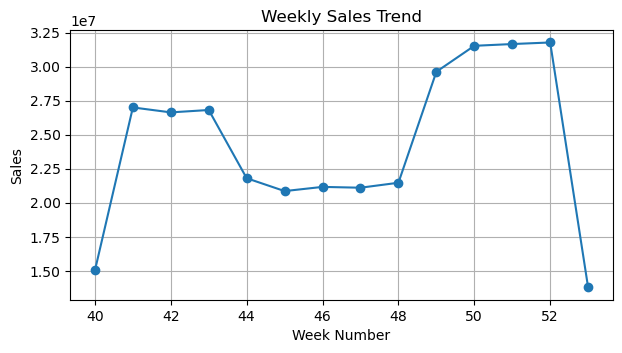

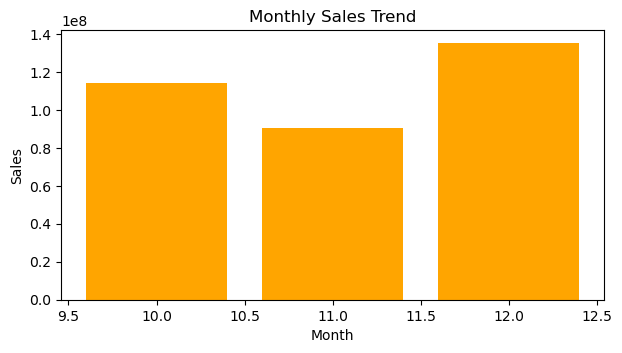

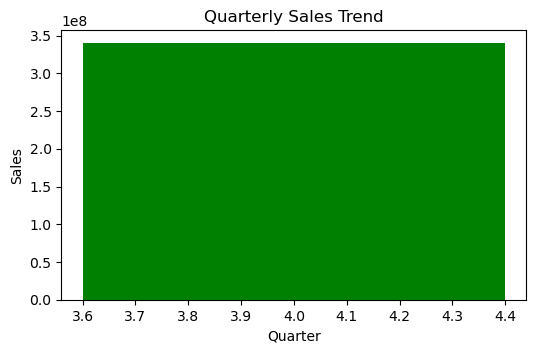

In [223]:
# Weekly Sales Plot
plt.figure(figsize=(7,3.5))
plt.plot(weekly_sales["Week"], weekly_sales["Sales"], marker="o")
plt.title("Weekly Sales Trend")
plt.xlabel("Week Number")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

# Monthly Sales Plot
plt.figure(figsize=(7,3.5))
plt.bar(monthly_sales["Month"], monthly_sales["Sales"], color='orange')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

# Quarterly Sales Plot
plt.figure(figsize=(6,3.5))
plt.bar(quarterly_sales["Quarter"], quarterly_sales["Sales"], color='green')
plt.title("Quarterly Sales Trend")
plt.xlabel("Quarter")
plt.ylabel("Sales")
plt.show()


In [224]:
# Step 15a: Key Insights (Top/Bottom + Peaks)

# State-wise totals
state_totals = df.groupby("State", as_index=False)["Sales"].sum().sort_values("Sales", ascending=False)
top_state    = state_totals.iloc[0]
bottom_state = state_totals.iloc[-1]

# Group-wise totals
group_totals = df.groupby("Group", as_index=False)["Sales"].sum().sort_values("Sales", ascending=False)
top_group    = group_totals.iloc[0]
bottom_group = group_totals.iloc[-1]

# Weekly / Monthly peaks (from your Step 13 tables)
weekly_peak   = weekly_sales.loc[weekly_sales["Sales"].idxmax()]
monthly_peak  = monthly_sales.loc[monthly_sales["Sales"].idxmax()]
quarter_total = float(quarterly_sales["Sales"].sum())

print("Top State      :", top_state["State"],  f"— ₹{top_state['Sales']:,.0f}")
print("Bottom State   :", bottom_state["State"], f"— ₹{bottom_state['Sales']:,.0f}")
print("Top Group      :", top_group["Group"],  f"— ₹{top_group['Sales']:,.0f}")
print("Bottom Group   :", bottom_group["Group"], f"— ₹{bottom_group['Sales']:,.0f}")
print("Peak Week      :", int(weekly_peak["Week"]),  f"— ₹{weekly_peak['Sales']:,.0f}")
print("Peak Month     :", int(monthly_peak["Month"]), f"— ₹{monthly_peak['Sales']:,.0f}")
print("Quarter Total  : ", f"₹{quarter_total:,.0f}")


Top State      :  VIC — ₹105,565,000
Bottom State   :  WA — ₹22,152,500
Top Group      :  Men — ₹85,750,000
Bottom Group   :  Seniors — ₹84,037,500
Peak Week      : 52 — ₹31,770,000
Peak Month     : 12 — ₹135,330,000
Quarter Total  :  ₹340,302,500


In [225]:
from IPython.display import Markdown, display

top_state    = state_totals.iloc[0]
bottom_state = state_totals.iloc[-1]
top_group    = group_totals.iloc[0]
bottom_group = group_totals.iloc[-1]
weekly_peak  = weekly_sales.loc[weekly_sales["Sales"].idxmax()]
monthly_peak = monthly_sales.loc[monthly_sales["Sales"].idxmax()]
quarter_total = float(quarterly_sales["Sales"].sum())

md = f"""
## Step 15 – Final Insights & Conclusion

**What sold best**
- **Top State:** {top_state['State']} — ₹{top_state['Sales']:,.0f} (highest)
- **Bottom State:** {bottom_state['State']} — ₹{bottom_state['Sales']:,.0f}
- **Top Group:** {top_group['Group']} — ₹{top_group['Sales']:,.0f}
- **Bottom Group:** {bottom_group['Group']} — ₹{bottom_group['Sales']:,.0f}

**Time trends (Q4)**
- **Peak Week:** {int(weekly_peak['Week'])} — ₹{weekly_peak['Sales']:,.0f}
- **Peak Month:** {int(monthly_peak['Month'])} ({"December" if int(monthly_peak['Month'])==12 else ""}) — ₹{monthly_peak['Sales']:,.0f}
- **Quarter Total:** ₹{quarter_total:,.0f}

### **Recommendations**
1. Increase inventory & ads in **{top_state['State']}**, **{top_group['Group']}**.
2. Give targeted discounts in **{bottom_state['State']}**, **{bottom_group['Group']}**.
3. Plan staffing & stock around peak **Week {int(weekly_peak['Week'])}** and **Month {int(monthly_peak['Month'])}**.
4. Track weekly & monthly KPIs, repeat this analysis next quarter.
"""

display(Markdown(md))



## Step 15 – Final Insights & Conclusion

**What sold best**
- **Top State:**  VIC — ₹105,565,000 (highest)
- **Bottom State:**  WA — ₹22,152,500
- **Top Group:**  Men — ₹85,750,000
- **Bottom Group:**  Seniors — ₹84,037,500

**Time trends (Q4)**
- **Peak Week:** 52 — ₹31,770,000
- **Peak Month:** 12 (December) — ₹135,330,000
- **Quarter Total:** ₹340,302,500

### **Recommendations**
1. Increase inventory & ads in ** VIC**, ** Men**.
2. Give targeted discounts in ** WA**, ** Seniors**.
3. Plan staffing & stock around peak **Week 52** and **Month 12**.
4. Track weekly & monthly KPIs, repeat this analysis next quarter.
